# Grocery Recommendation Project

1. Data Clustering on users  
2. Recommendation systems
  * Content-based filtering  
  * Collaborative filtering  
3. Metadata NLP Search Engine
3. Market Basket analysis  
4. Website interface  

For this analysis I will be working as a Data Scientist for a grocery store that is looking to discover insights from sales data that could be used for targeted direct mail marketing (specific coupons mailed to customers), targeted email marketing ("An item you like has gone on sale!"), and online shopper recommendations to 'add to cart' based on similar items and also based on items other people who bought that item have purchased.  

If time permits, I may also perform a market basket analysis to forecast what products a customer is likely to purchase in their next order.

## Dataset information

This data was retrieved from Kaggle and was provided by Instacart for a market basket analysis competition in 2018.  

The data is divided into 6 files:

- **_Aisles.csv_**: 134 Unique aisle numbers and descriptions
- **_Departments.csv_**: 21 Unique department numbers and descriptions
- **_Products.csv_**: 49,688 Unique product ids, with description, aisle id, and department id
- **_Orders.csv_**: 3,421,083 Unique order id, with user id, order number, order_dow, order_hour_of_day, days_since_prior_order, and eval_set indicating if the order is in train, prior, or test
- **_Order_products_train.csv_**: Order id, product id, add to cart order, and reorder indicator
- **_Order_products_prior.csv_**: Order id, product id, add to cart order, and reorder indicator


## Exploratory Data Analysis

### Import and basic info

**Output** - aisles, orders, products, departments, order_products_prior, order_products_train

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set default visualization parameters

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
sns.set_context("notebook", rc={"font.size":16, "axes.titlesize":20, "axes.labelsize":18})
sns.set(font='Franklin Gothic Book',
rc={'axes.axisbelow': False,
'axes.edgecolor': 'lightgrey',
# 'axes.edgecolor': 'white',
'axes.facecolor': 'None',
'axes.grid': False,
'axes.labelcolor': 'dimgrey',
# 'axes.labelcolor': 'white',
'axes.spines.right': False,
'axes.spines.top': False,
'axes.prop_cycle': plt.cycler(color=color_list),
'figure.facecolor': 'white',
'lines.solid_capstyle': 'round',
'patch.edgecolor': 'w',
'patch.force_edgecolor': True,
'text.color': 'dimgrey',
# 'text.color': 'white',
'xtick.bottom': False,
'xtick.color': 'dimgrey',
# 'xtick.color': 'white',
'xtick.direction': 'out',
'xtick.top': False,
'ytick.color': 'dimgrey',
# 'ytick.color': 'white',
'ytick.direction': 'out',
'ytick.left': False,
'ytick.right': False})
%matplotlib inline

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [ ]:
aisles = pd.read_csv("/content/aisles.csv")
departments = pd.read_csv("/content/departments.csv")
order_products_prior = pd.read_csv("/content/order_products__prior.csv")
order_products_train = pd.read_csv("/content/order_products__train.csv")
orders = pd.read_csv("/content/orders.csv")
products = pd.read_csv("/content/products.csv")

### Checking for Nan values

Data is very clean. Nan values in orders.days_since_prior_order, but they are valid.

In [ ]:
aisles.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [ ]:
departments.isna().sum()

department_id    0
department       0
dtype: int64

In [ ]:
products.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [ ]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [ ]:
orders.days_since_prior_order.value_counts()
# Nothing greater than 30 here so it must actually be '30+'

30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
2.0     193206
8.0     181717
1.0     145247
9.0     118188
14.0    100230
10.0     95186
13.0     83214
11.0     80970
12.0     76146
0.0      67755
15.0     66579
16.0     46941
21.0     45470
17.0     39245
20.0     38527
18.0     35881
19.0     34384
22.0     32012
28.0     26777
23.0     23885
27.0     22013
24.0     20712
25.0     19234
29.0     19191
26.0     19016
Name: days_since_prior_order, dtype: int64

In [ ]:
orders.head()
# order_id is a unique key for the order
# order_number is specific to a user
# seems like for any user, order 1 will have a Nan in days_since_prior_order since it is their first order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
order_products_train.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [ ]:
order_products_prior.isna().sum()

order_id             0
product_id           1
add_to_cart_order    1
reordered            1
dtype: int64

### Analyze 'Products'
  
49688 unique products

In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
print(len(products))
print(products.aisle_id.nunique())
print(products.department_id.nunique())

49688
134
21


In [ ]:
# How many products in each department and aisle?
# I guess these would be better/more informative with aisle and dept names
products_aisles = pd.merge(products, aisles, on = 'aisle_id', how = 'left')
products_desc = pd.merge(products_aisles, departments, on = 'department_id', how = 'left')
products_desc.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


Text(0.5, 0, 'Department')

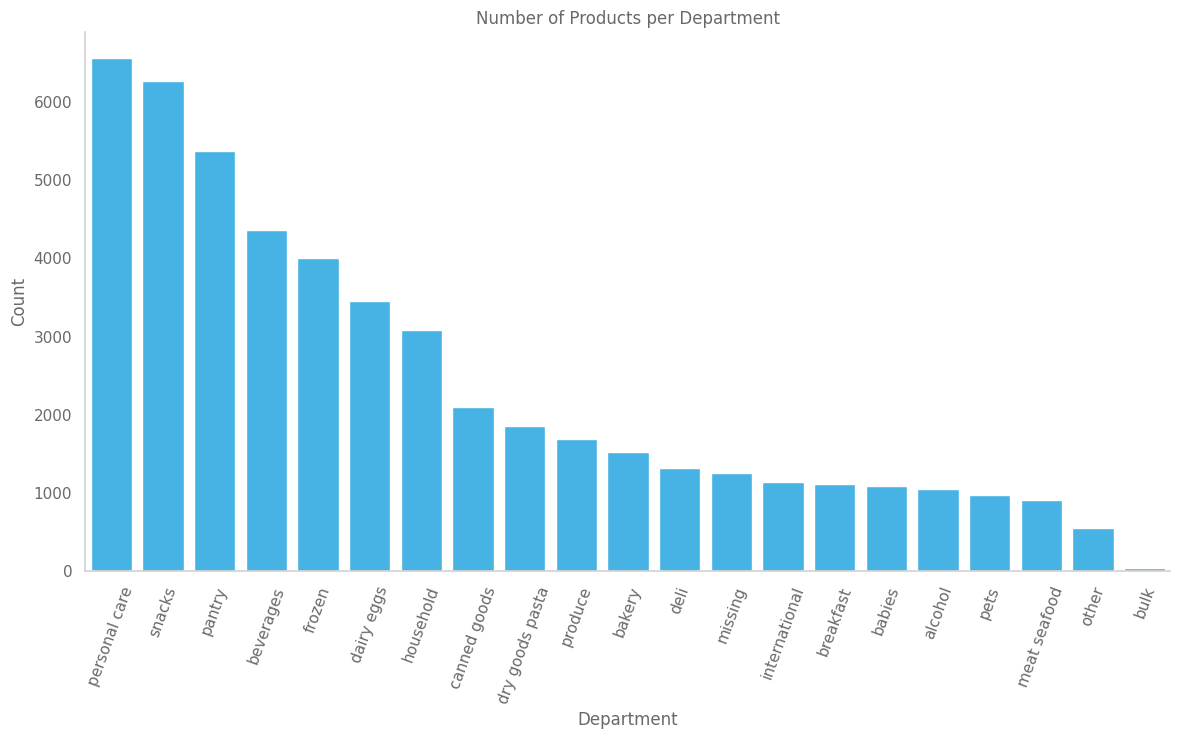

In [ ]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= products_desc, order = products_desc.department.value_counts().index)
plt.title('Number of Products per Department')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Department')


Text(0.5, 0, 'Aisle')

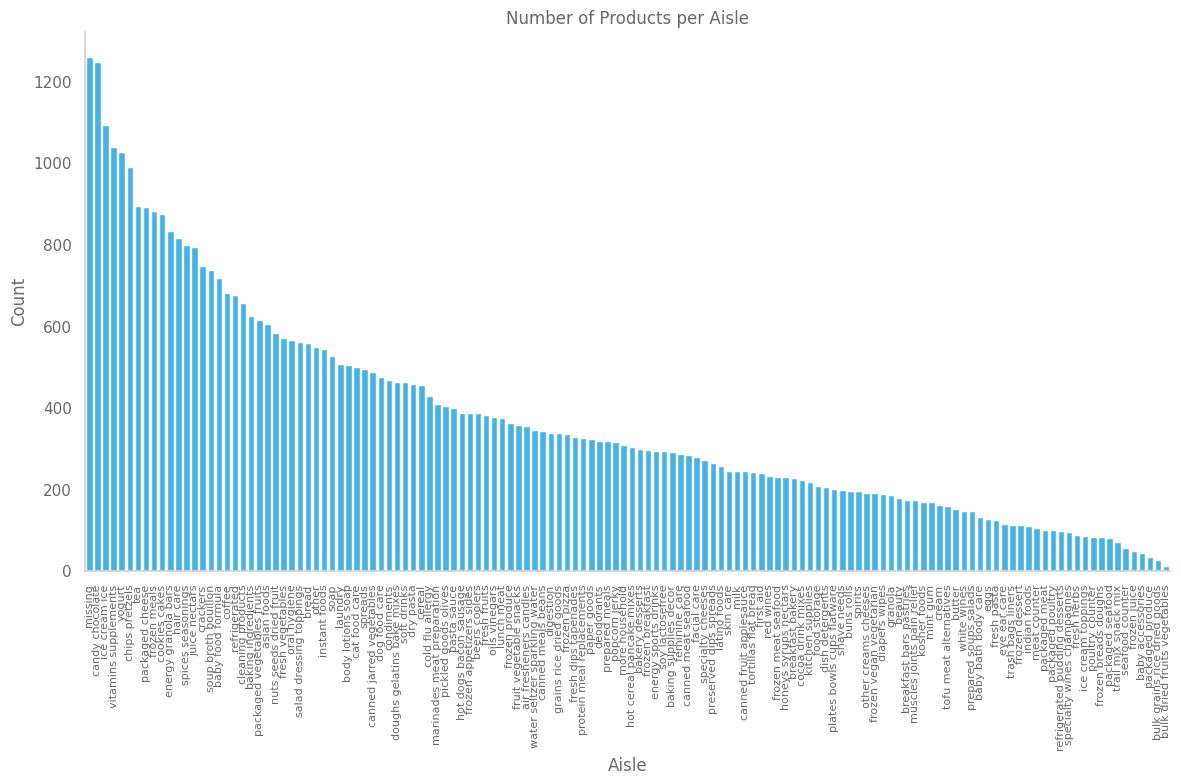

In [ ]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= products_desc, order = products_desc.aisle.value_counts().index)
plt.title('Number of Products per Aisle')
plt.xticks(rotation=90, fontsize = 8)
plt.ylabel('Count')
plt.xlabel('Aisle')

# Uh oh, 'missing' is our most popular aisle
# And I see there is a 'missing' value for department above as well

In [ ]:
products_desc[products_desc['aisle']=='missing']
# It appears that 1258 products have 'missing' aisle 100 and department 21

,product_id,product_name,aisle_id,department_id,aisle,department
37,38,Ultra Antibacterial Dish Liquid,100,21,missing,missing
71,72,Organic Honeycrisp Apples,100,21,missing,missing
109,110,Uncured Turkey Bologna,100,21,missing,missing
296,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21,missing,missing
416,417,Classics Baby Binks Easter Chocolate Bunny,100,21,missing,missing
...,...,...,...,...,...,...
49552,49553,Organic Plain Skyr,100,21,missing,missing
49574,49575,Chocolate Vanilla Malt Custard,100,21,missing,missing
49640,49641,"8\"" Pecan Pie",100,21,missing,missing
49663,49664,Lemon Cayenne Drinking Vinegar,100,21,missing,missing


In [ ]:
# Just confirming the one to many relationship between department and aisle
products_desc[products_desc['department']=='snacks']

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
15,16,Mint Chocolate Flavored Syrup,103,19,ice cream toppings,snacks
24,25,Salted Caramel Lean Protein & Fiber Bar,3,19,energy granola bars,snacks
31,32,Nacho Cheese White Bean Chips,107,19,chips pretzels,snacks
40,41,Organic Sourdough Einkorn Crackers Rosemary,78,19,crackers,snacks
...,...,...,...,...,...,...
49661,49662,Bacon Cheddar Pretzel Pieces,107,19,chips pretzels,snacks
49664,49665,Super Dark Coconut Ash & Banana Chocolate Bar,45,19,candy chocolate,snacks
49665,49666,Ginger Snaps Snacking Cookies,61,19,cookies cakes,snacks
49670,49671,Milk Chocolate Drops,45,19,candy chocolate,snacks


In [ ]:
# An aisle only belongs to one department
products_desc[products_desc['aisle_id']==45]

,product_id,product_name,aisle_id,department_id,aisle,department
123,124,Sun Cups Dark Chocolate,45,19,candy chocolate,snacks
135,136,Simple,45,19,candy chocolate,snacks
183,184,Kisses Milk Chocolate Candy,45,19,candy chocolate,snacks
206,207,Minis Candy Bars,45,19,candy chocolate,snacks
226,227,Triple Chocolate Snack Size,45,19,candy chocolate,snacks
...,...,...,...,...,...,...
49503,49504,Dark Chocolate Peanut Butter Cups Miniatures,45,19,candy chocolate,snacks
49600,49601,Pomegranate Gummy Bears,45,19,candy chocolate,snacks
49619,49620,Milk Chocolate Mini's,45,19,candy chocolate,snacks
49664,49665,Super Dark Coconut Ash & Banana Chocolate Bar,45,19,candy chocolate,snacks


### Analyze Orders

In [ ]:
print(len(orders))
print(orders.order_id.min())
print(orders.order_id.max())

3421083
1
3421083


Text(0.5, 0, 'Hour')

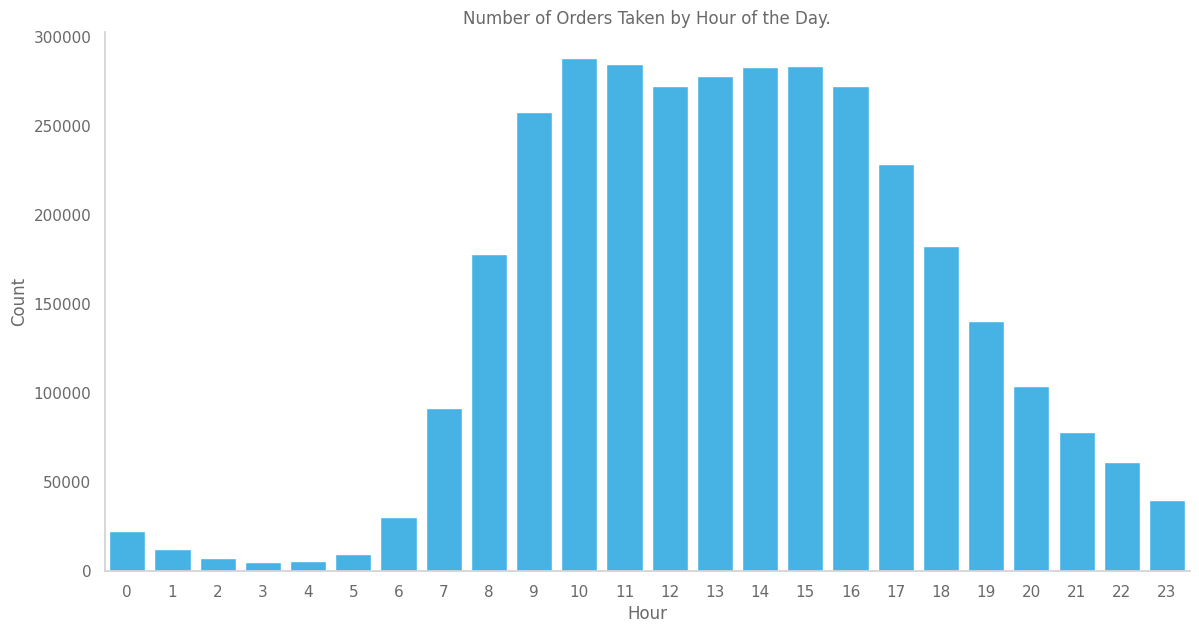

In [ ]:
plt.figure(figsize = (14,7))
sns.countplot(x='order_hour_of_day', data= orders)
plt.title('Number of Orders Taken by Hour of the Day.')
plt.ylabel('Count')
plt.xlabel('Hour')


Text(0.5, 0, 'Day')

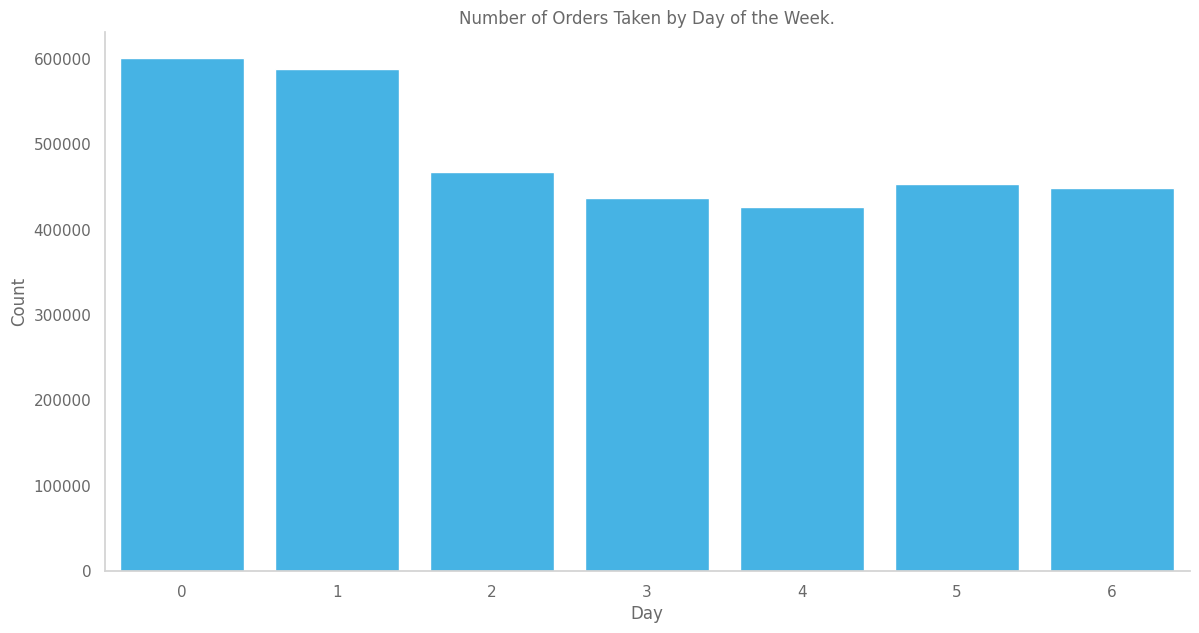

In [ ]:
plt.figure(figsize = (14,7))
sns.countplot(x='order_dow', data= orders)
plt.title('Number of Orders Taken by Day of the Week.')
plt.ylabel('Count')
plt.xlabel('Day')


Text(0.5, 0, 'Days')

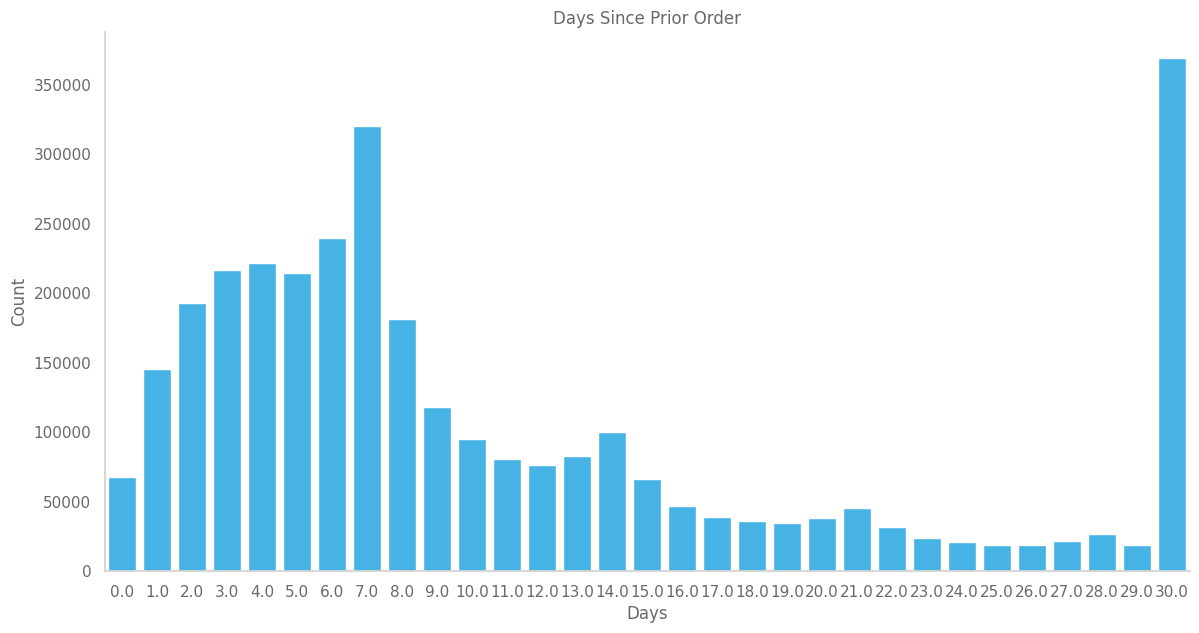

In [ ]:
plt.figure(figsize = (14,7))
sns.countplot(x='days_since_prior_order', data= orders)
plt.title('Days Since Prior Order')
plt.ylabel('Count')
plt.xlabel('Days')


# Spikes at 7, 14, 21, and 28 indicate people who reorder weekly, or every 2 or three weeks but on the same day
# Does 0.0 days mean someone ordered twice in the same day?
# Surprising how many people order more than once a week
# 30 does seem to indicate 30 or more days since last order

In [ ]:
orders.head(15)
# Appears to be sorted by user_id and then order_number
# Most recent order_number per user_id is in the train(or test) set, others in prior
# First order per user has NaN in days_since

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [ ]:
orders.sort_values('order_id') # Just checking that it has all the order_ids starting at 1

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0
...,...,...,...,...,...,...,...
1809968,3421079,108687,prior,6,1,13,0.0
877324,3421080,52726,prior,2,1,11,2.0
1949724,3421081,117076,prior,1,3,11,NaN
2903252,3421082,175185,prior,23,2,18,4.0


In [ ]:
orders_test = orders[orders['eval_set']=='test'] # 75000 orders in our test set
# So basically for these test orders, I don't have the answers.  I don't know what products were ordered.
# If I do market basket analysis I will get to these
orders_test

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0


In [ ]:
orders[orders['user_id']==3] # But I have all of this user's order/products in prior

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


### Analyze Order_products_train and _prior

In [ ]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
print(len(order_products_train)) # Has 1,384,617 order/products
print(order_products_train.order_id.min()) # starts with order number 1
print(order_products_train.order_id.max())
print(order_products_train.order_id.nunique()) # Has 131,209 unique orders

1384617
1
3421070
131209


In [ ]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
2,2,9327.0,3.0,0.0
3,2,45918.0,4.0,1.0
4,2,30035.0,5.0,0.0


In [ ]:
print(len(order_products_prior)) # Has 32,434,489 order/products
print(order_products_prior.order_id.min()) # starts with order number 2
print(order_products_prior.order_id.max())
print(order_products_prior.order_id.nunique()) # Has 3,214,874 unique orders

25968866
2
2738566
2573359


In [ ]:
order_products_prior[order_products_prior.order_id == 2]

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
2,2,9327.0,3.0,0.0
3,2,45918.0,4.0,1.0
4,2,30035.0,5.0,0.0
5,2,17794.0,6.0,1.0
6,2,40141.0,7.0,1.0
7,2,1819.0,8.0,1.0
8,2,43668.0,9.0,0.0


In [ ]:
orders[orders.order_id == 2]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355525,2,202279,prior,3,5,9,8.0


In [ ]:
orders[orders.user_id == 202279]
# This user's third order was order number 2.  Need to be sure not to think order_id is chronological.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355523,2894949,202279,prior,1,5,9,NaN
3355524,1500071,202279,prior,2,4,13,20.0
3355525,2,202279,prior,3,5,9,8.0
3355526,3058248,202279,prior,4,3,14,30.0
3355527,2808715,202279,prior,5,5,13,9.0
3355528,132412,202279,prior,6,5,9,30.0
3355529,2382766,202279,prior,7,1,14,24.0
3355530,104690,202279,prior,8,6,10,30.0
3355531,1050357,202279,train,9,1,14,30.0


In [ ]:
order_products_train[order_products_train.order_id == 1050357]

,order_id,product_id,add_to_cart_order,reordered
429686,1050357,33120,1,1
429687,1050357,1003,2,1
429688,1050357,21543,3,1
429689,1050357,20995,4,1
429690,1050357,46064,5,0
429691,1050357,20168,6,0
429692,1050357,42824,7,1
429693,1050357,4461,8,1
429694,1050357,45002,9,1
429695,1050357,8693,10,0


In [ ]:
# So what do I know about this user...

# They have ordered 9 times.
len(orders[orders.user_id == 202279])

9

In [ ]:
# They usually order on day 5 (presumably Friday)
orders[orders.user_id == 202279].order_dow.mode()

0    5
Name: order_dow, dtype: int64

In [ ]:
# They average 22.6 days between orders
orders[orders.user_id == 202279].days_since_prior_order.mean()

22.625

In [ ]:
# They order around 11:30 am.
orders[orders.user_id == 202279].order_hour_of_day.mean()

11.666666666666666

In [ ]:
# These are their order numbers
list(orders[orders.user_id == 202279]['order_id'].values)

[2894949, 1500071, 2, 3058248, 2808715, 132412, 2382766, 104690, 1050357]

In [ ]:
# But what products have they ordered... merging tables will help here
order_products_prior[order_products_prior['order_id'].isin(list(orders[orders.user_id == 202279]['order_id'].values))]

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
2,2,9327.0,3.0,0.0
3,2,45918.0,4.0,1.0
4,2,30035.0,5.0,0.0
...,...,...,...,...
22590998,2382766,2086.0,13.0,0.0
22590999,2382766,48023.0,14.0,1.0
22591000,2382766,47969.0,15.0,0.0
22591001,2382766,29130.0,16.0,0.0


## Data Preprocessing

### Merge order_products together

Output: merged_order_products, order_products_desc

In [ ]:
print(len(order_products_train))
print(len(order_products_prior))

1384617
25968866


In [ ]:
# The dataframe of all order products should be the length of these two together
len(order_products_train)+len(order_products_prior)

27353483

In [ ]:
# These two dataframes shouldn't have any overlap.  I need an outer join to merge them together.
merged_order_products = pd.merge(order_products_train, order_products_prior, how = 'outer')
merged_order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302.0,1.0,1.0
1,1,11109.0,2.0,1.0
2,1,10246.0,3.0,0.0
3,1,49683.0,4.0,0.0
4,1,43633.0,5.0,1.0


In [ ]:
len(merged_order_products)

27353483

In [ ]:
products_per_order = merged_order_products.groupby('order_id').count()

Text(0.5, 0, 'Products')

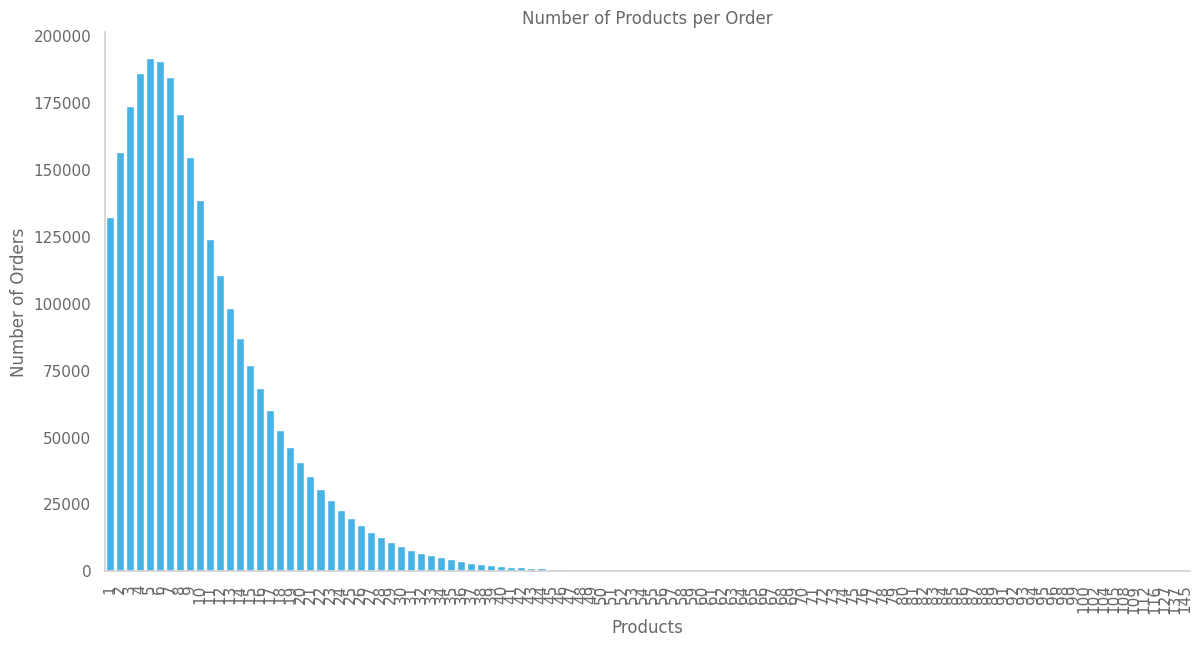

In [ ]:
# 5 is the most common number of products per order

plt.figure(figsize = (14,7))
sns.countplot(x='product_id', data = products_per_order)
plt.title('Number of Products per Order')
plt.xticks(rotation=90)
plt.ylabel('Number of Orders')
plt.xlabel('Products')


In [ ]:
# This has an entry for each ordered product.  If we combine it with aisle and department we can see which products
# are ordered the most.
order_products_desc = pd.merge(merged_order_products, products_desc, on = 'product_id')
order_products_desc.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302.0,1.0,1.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302.0,7.0,1.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302.0,1.0,1.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302.0,11.0,1.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302.0,8.0,0.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [ ]:
order_products_desc.shape

(27353482, 9)

In [ ]:
order_products_desc.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department'],
      dtype='object')

In [ ]:
# Very cool.  People really like their bananas.
order_products_desc['product_name'].value_counts()

Banana                              397734
Bag of Organic Bananas              319374
Organic Strawberries                222972
Organic Baby Spinach                203269
Organic Hass Avocado                178255
                                     ...  
Acai Dragonfruit Melon Green Tea         1
Ultra Bath Tissue Rolls                  1
Rosemary Flaxseed Crackers               1
Pumpkin Spice Almond Nog                 1
Translucent Bronzing Tint                1
Name: product_name, Length: 49643, dtype: int64

In [ ]:
top_60_products = order_products_desc['product_name'].value_counts().head(60)
print(top_60_products)

Banana                                  397734
Bag of Organic Bananas                  319374
Organic Strawberries                    222972
Organic Baby Spinach                    203269
Organic Hass Avocado                    178255
Organic Avocado                         149116
Large Lemon                             130474
Strawberries                            120794
Limes                                   118460
Organic Whole Milk                      115397
Organic Raspberries                     115076
Organic Yellow Onion                     95054
Organic Garlic                           92047
Organic Zucchini                         88365
Organic Blueberries                      85005
Cucumber Kirby                           80207
Organic Fuji Apple                       75041
Organic Lemon                            73557
Organic Grape Tomatoes                   71394
Apple Honeycrisp Organic                 70373
Seedless Red Grapes                      70309
Organic Cucum

In [ ]:
top_products_60_to_120 = order_products_desc['product_name'].value_counts().iloc[60:121]
print(top_products_60_to_120)

Unsweetened Almondmilk           42022
Organic Kiwi                     41874
Organic D'Anjou Pears            41044
Organic Reduced Fat 2% Milk      39738
Lime Sparkling Water             39316
                                 ...  
Fat Free Milk                    24731
Organic Extra Firm Tofu          24450
Pure Sparkling Water             24283
Green Beans                      24277
Organic Roasted Turkey Breast    23739
Name: product_name, Length: 61, dtype: int64


In [ ]:
top_products_121_to_181 = order_products_desc['product_name'].value_counts().iloc[121:181]
print(top_products_121_to_181)

No Salt Added Black Beans                                23523
100% Recycled Paper Towels                               23430
Organic Milk                                             23255
Organic Coconut Milk                                     23010
Organic Red Radish, Bunch                                22784
Green Onions                                             22753
Honey Nut Cheerios                                       22637
Organic Basil                                            22621
Red Raspberries                                          22541
Total 0% Nonfat Greek Yogurt                             22536
Shredded Mild Cheddar Cheese                             22410
Ground Turkey Breast                                     22350
Organic Sour Cream                                       22324
Unsweetened Vanilla Almond Milk                          22256
Total Greek Strained Yogurt                              22169
Organic Fat Free Milk                                  

Text(0.5, 0, 'Product Name')

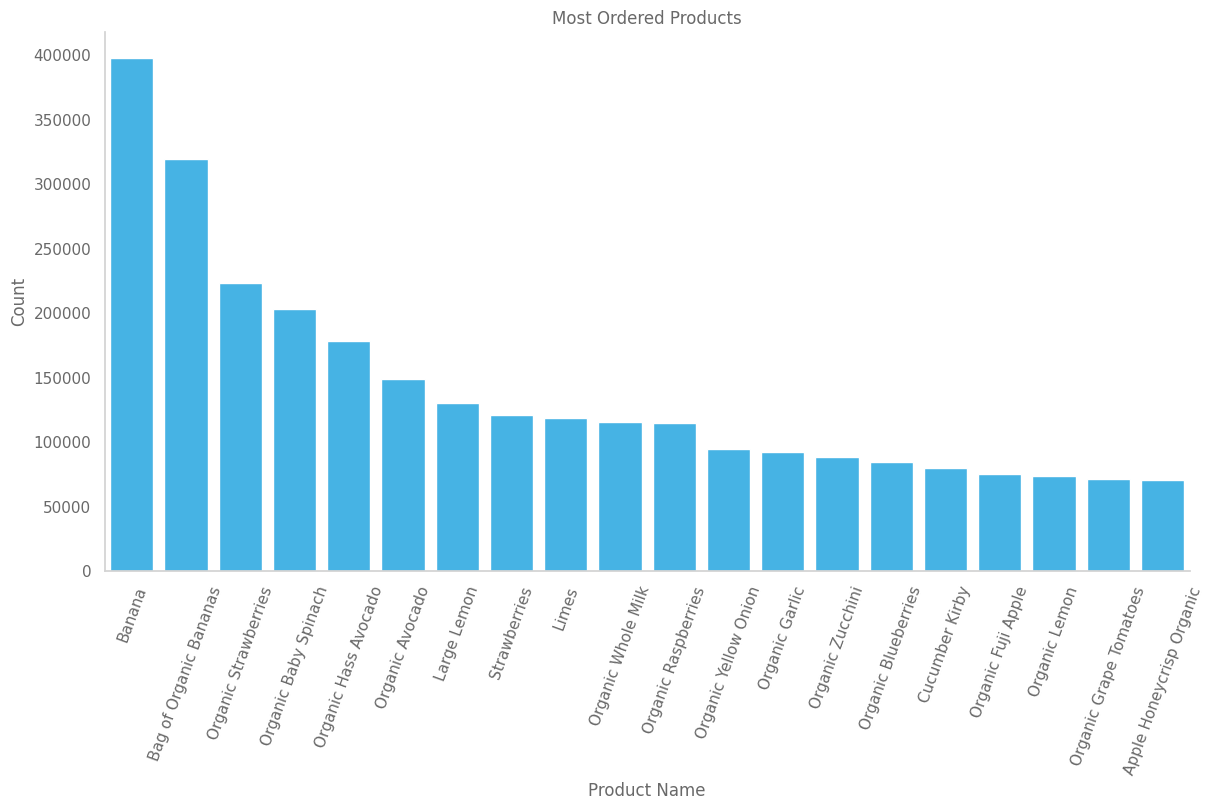

In [ ]:
plt.figure(figsize = (14,7))
sns.countplot(x='product_name', data= order_products_desc,
              order = order_products_desc.product_name.value_counts().index[:20])
plt.title('Most Ordered Products')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Product Name')


Text(0.5, 0, 'Product Name')

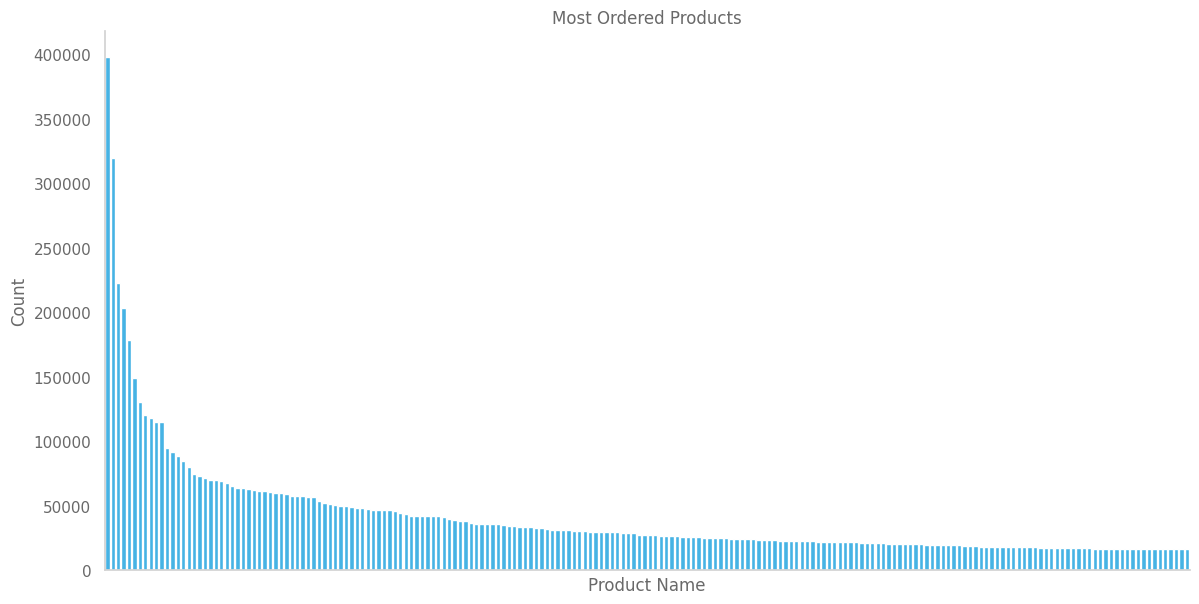

In [ ]:
plt.figure(figsize = (14,7))
sns.countplot(x='product_name', data= order_products_desc,
              order = order_products_desc.product_name.value_counts().index[:200])
plt.title('Most Ordered Products')
plt.xticks([])
plt.ylabel('Count')
plt.xlabel('Product Name')


Text(0.5, 0, 'Department')

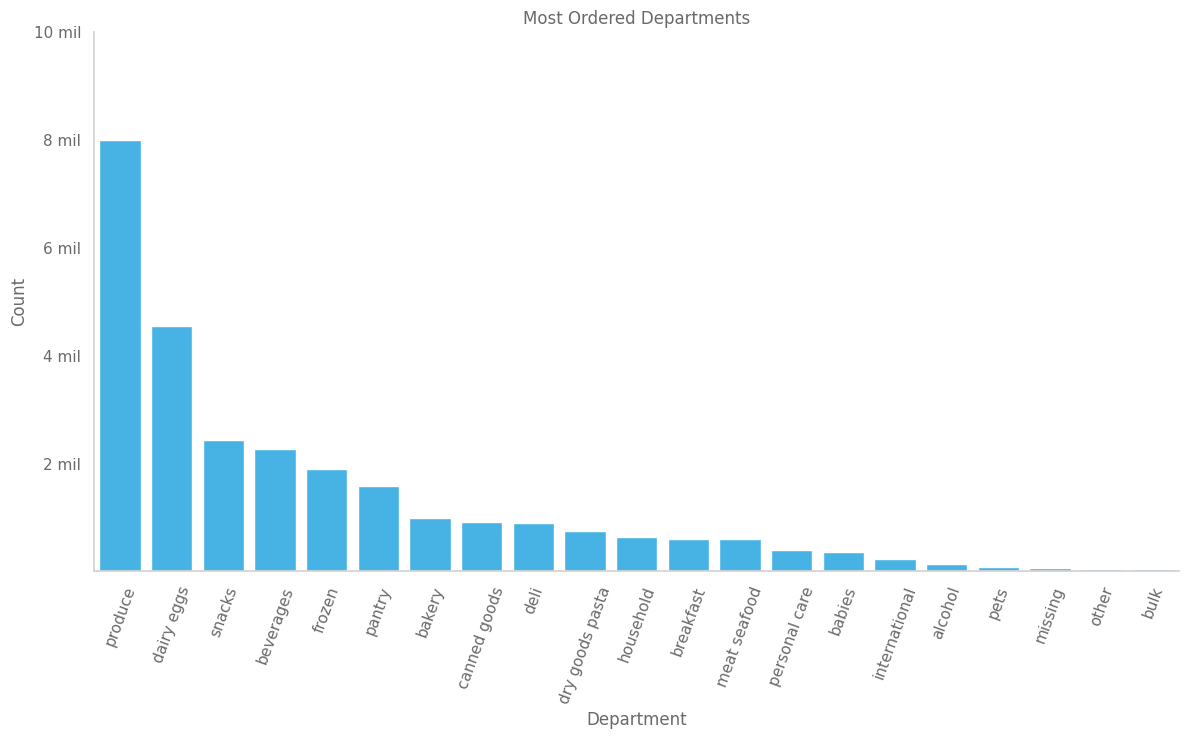

In [ ]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= order_products_desc, order = order_products_desc.department.value_counts().index)
plt.title('Most Ordered Departments')
plt.xticks(rotation=70)
plt.yticks([2000000,4000000,6000000,8000000,10000000],['2 mil','4 mil','6 mil','8 mil','10 mil'])
plt.ylabel('Count')
plt.xlabel('Department')


Text(0.5, 0, 'Aisle')

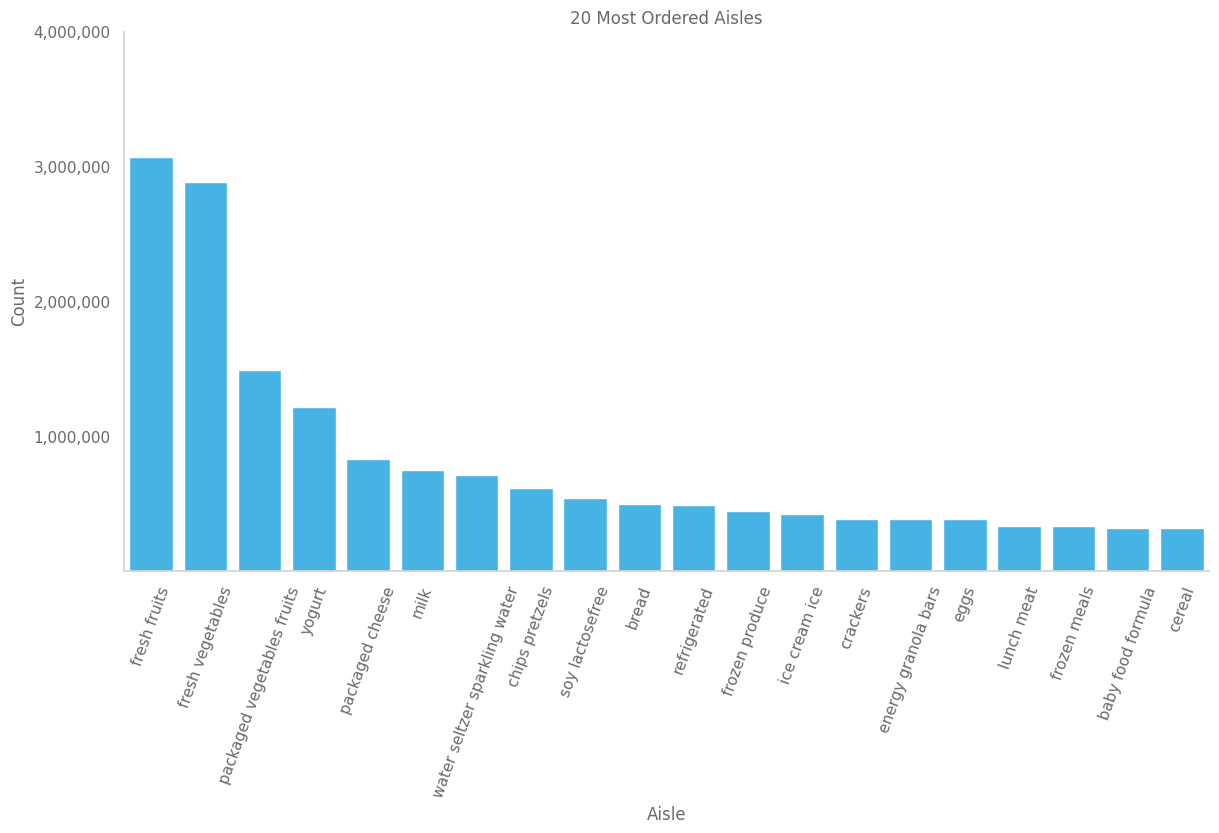

In [ ]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= order_products_desc, order = order_products_desc.aisle.value_counts().index[:20])
plt.title('20 Most Ordered Aisles')
plt.xticks(rotation=70)
plt.yticks([1000000,2000000,3000000,4000000],['1,000,000','2,000,000','3,000,000','4,000,000'])
plt.ylabel('Count')
plt.xlabel('Aisle')


### Merge user orders

Output: merged_orders

In [ ]:
# Now merge the orders with the ordered prodcuts, combining on order_id
# This is a lot of info. We will trim some out before modeling.
merged_orders = pd.merge(orders, order_products_desc, on = 'order_id')
merged_orders.head() # Because the products showing are from the 1st order for this user, they all have Nan in days_since
# Because pd.merge defaults to an inner join, the test orders are not in this dataframe because they had no products.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
2,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
3,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23,19,popcorn jerky,snacks


In [ ]:
len(merged_orders)

27353482

In [ ]:
merged_orders[merged_orders['user_id']==3] # We see 12 orders, 88 products, no test order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
244,1374495,3,prior,1,1,14,NaN,39190.0,5.0,0.0,Vanilla Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs
245,1374495,3,prior,1,1,14,NaN,16797.0,4.0,0.0,Strawberries,24,4,fresh fruits,produce
246,1374495,3,prior,1,1,14,NaN,9387.0,1.0,0.0,Granny Smith Apples,24,4,fresh fruits,produce
247,1374495,3,prior,1,1,14,NaN,21903.0,7.0,0.0,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
248,1374495,3,prior,1,1,14,NaN,39922.0,8.0,0.0,Celery Sticks,123,4,packaged vegetables fruits,produce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,1402502,3,prior,12,1,15,15.0,18599.0,2.0,1.0,Garlic Couscous,4,9,instant foods,dry goods pasta
309,1402502,3,prior,12,1,15,15.0,21903.0,4.0,1.0,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
310,1402502,3,prior,12,1,15,15.0,47766.0,5.0,1.0,Organic Avocado,24,4,fresh fruits,produce
311,1402502,3,prior,12,1,15,15.0,24810.0,6.0,1.0,Organic Lightly Salted Brown Rice Cakes,78,19,crackers,snacks


In [ ]:
orders[orders['user_id']==3]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


In [ ]:
# Creating the test set of orders
test = orders[orders['eval_set']=='test']
test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [ ]:
# Now I can see everything a particular user has ordered, and how often
merged_orders[merged_orders['user_id']==3]['product_name'].value_counts()

Vanilla Unsweetened Almond Milk                    7
Organic Baby Spinach                               6
Organic Avocado                                    6
Granny Smith Apples                                5
Unsweetened Chocolate Almond Breeze Almond Milk    5
All Natural No Stir Creamy Almond Butter           3
Organic Lightly Salted Brown Rice Cakes            3
Crackers, Crispy, Cheddar                          3
Garlic Couscous                                    3
Brussels Sprouts                                   2
Wheat Gluten Free Waffles                          2
Electrolyte Water                                  2
Strawberries                                       2
Green Beans                                        2
Organic Whole String Cheese                        2
Organic Peeled Whole Baby Carrots                  2
Chocolate Ice Cream                                2
Organic Shredded Mozzarella                        1
Original Rotisserie Chicken                   

# Recommendation system

## EDA of recommendation(Food production Column)

Importing the file

In [ ]:
Food_production = pd.read_csv("/content/Food_Production.csv")

In [ ]:
Food_production

,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),...,Freshwater withdrawals per 100g protein (liters per 100g protein),Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein),Land use per 1000kcal (m² per 1000kcal),Land use per kilogram (m² per kilogram),Land use per 100g protein (m² per 100g protein),Scarcity-weighted water use per kilogram (liters per kilogram),Scarcity-weighted water use per 100g protein (liters per 100g protein),Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,...,371.076923,482.4,0.945482,1.907692,2.897446,7.60,5.846154,18786.2,14450.923080,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,...,3166.760563,2248.4,1.207271,6.267606,0.759631,2.80,3.943662,49576.3,69825.774650,13449.891480
5,Potatoes,0.0,0.0,0.2,0.0,0.1,0.0,0.0,0.3,4.754098,...,347.647059,59.1,0.628415,2.705882,1.202186,0.88,5.176471,2754.2,16201.176470,3762.568306
6,Cassava,0.6,0.0,0.2,0.0,0.1,0.0,0.0,0.9,0.708419,...,NaN,0.0,1.355236,14.666667,1.858316,1.81,20.111111,0.0,NaN,NaN
7,Cane Sugar,1.2,0.0,0.5,0.0,0.8,0.1,0.0,2.6,4.820513,...,NaN,620.1,0.911681,NaN,0.581197,2.04,NaN,16438.6,NaN,4683.361823
8,Beet Sugar,0.0,0.0,0.5,0.2,0.6,0.1,0.0,1.4,1.541311,...,NaN,217.7,0.515670,NaN,0.521368,1.83,NaN,9493.3,NaN,2704.643875
9,Other Pulses,0.0,0.0,1.1,0.0,0.1,0.4,0.0,1.6,5.008798,...,203.503036,435.7,0.524927,0.836058,4.565982,15.57,7.272303,22477.4,10498.552080,NaN


In [ ]:
Food_production.columns

Index(['Food product', 'Land use change', 'Animal Feed', 'Farm', 'Processing',
       'Transport', 'Packging', 'Retail', 'Total_emissions',
       'Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)',
       'Eutrophying emissions per kilogram (gPO₄eq per kilogram)',
       'Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)',
       'Freshwater withdrawals per 1000kcal (liters per 1000kcal)',
       'Freshwater withdrawals per 100g protein (liters per 100g protein)',
       'Freshwater withdrawals per kilogram (liters per kilogram)',
       'Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)',
       'Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)',
       'Land use per 1000kcal (m² per 1000kcal)',
       'Land use per kilogram (m² per kilogram)',
       'Land use per 100g protein (m² per 100g protein)',
       'Scarcity-weighted water use per kilogram (liters per kilogram)',
       'Scarcity-weighted water use per 100g protein 

In [ ]:
columns_to_drop = ['Land use change', 'Land use change', 'Animal Feed', 'Farm', 'Processing',
       'Transport', 'Packging', 'Retail','Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)',
       'Eutrophying emissions per kilogram (gPO₄eq per kilogram)',
       'Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)',
       'Freshwater withdrawals per 1000kcal (liters per 1000kcal)',
       'Freshwater withdrawals per 100g protein (liters per 100g protein)',
       'Freshwater withdrawals per kilogram (liters per kilogram)',
       'Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)',
       'Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)',
       'Land use per 1000kcal (m² per 1000kcal)',
       'Land use per kilogram (m² per kilogram)',
       'Land use per 100g protein (m² per 100g protein)',
       'Scarcity-weighted water use per kilogram (liters per kilogram)',
       'Scarcity-weighted water use per 100g protein (liters per 100g protein)',
       'Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)']
Food_production.drop(columns_to_drop, axis=1, inplace = True )

In [ ]:
Food_production

,Food product,Total_emissions
0,Wheat & Rye (Bread),1.4
1,Maize (Meal),1.1
2,Barley (Beer),1.1
3,Oatmeal,1.6
4,Rice,4.0
5,Potatoes,0.3
6,Cassava,0.9
7,Cane Sugar,2.6
8,Beet Sugar,1.4
9,Other Pulses,1.6


In [ ]:
# adding new data manually
new_rows = [
    {'Food product': 'Strawberries', 'Total_emissions': 0.9},
    {'Food product': 'Spinach', 'Total_emissions': 0.8},
    {'Food product': 'Avocado', 'Total_emissions': 1.5},
    {'Food product': 'Milk', 'Total_emissions': 2},
    {'Food product': 'Broccoli', 'Total_emissions': 2},
    {'Food product': 'Bread', 'Total_emissions': 1},
    {'Food product': 'Blueberries', 'Total_emissions': 2.4},
    {'Food product': 'Cheese', 'Total_emissions': 3},
    {'Food product': 'Carrots', 'Total_emissions': 2.8},
    {'Food product': 'Pepper', 'Total_emissions': 3.2},
    {'Food product': 'Potato', 'Total_emissions': 2},
    {'Food product': 'Celery', 'Total_emissions': 3.3},
    {'Food product': 'Kale', 'Total_emissions': 3.4},
    {'Food product': 'Crisp', 'Total_emissions': 3.5},
    {'Food product': 'Arugula', 'Total_emissions': 3.6},
    {'Food product': 'Onion', 'Total_emissions': 3.7},
    {'Food product': 'Chicken', 'Total_emissions': 4},
    {'Food product': 'Banana', 'Total_emissions': 1}
]

Food_production = Food_production.append(new_rows,ignore_index = True)


In [ ]:
additional_data = {
    'Food product': ['Pasta', 'Bread', 'Chicken', 'Pork', 'Beef', 'Lamb', 'Cheese', 'Butter', 'Rice', 'Potatoes', 'Tomatoes', 'Apples', 'Bananas', 'Oranges', 'Strawberries', 'Peas', 'Lentils', 'Almonds', 'Walnuts', 'Olive oil', 'Sunflower oil', 'Canola oil', 'Soybean oil', 'Palm oil', 'Coconut oil', 'Avocado', 'Tofu', 'Soy milk', 'Almond milk', 'Oat milk', 'Cow milk', 'Eggs', 'Honey', 'Sugar', 'Salt', 'Coffee', 'Tea', 'Cocoa', 'Wine', 'Beer', 'Whiskey', 'Vodka', 'Rum', 'Gin', 'Tequila', 'Sake', 'Cider', 'Champagne', 'Brandy', 'Absinthe'],
    'Total_emissions': [1.3, 0.8, 6.9, 7.9, 27.0, 39.2, 13.5, 12.1, 4.0, 0.3, 1.4, 0.3, 0.8, 0.3, 0.7, 0.8, 0.9, 0.7, 0.2, 6.0, 3.5, 3.7, 6.0, 7.6, 6.1, 2.0, 3.0, 1.0, 1.1, 1.4, 2.8, 4.5, 0.6, 2.6, 0.1, 16.5, 0.2, 3.2, 1.4, 1.1, 2.7, 2.1, 2.3, 2.2, 2.3, 2.1, 1.2, 1.3, 1.4, 1.2]
}

additional_df = pd.DataFrame(additional_data)

Food_production = pd.concat([Food_production, additional_df])




Food_production

,Food product,Total_emissions
0,Wheat & Rye (Bread),1.4
1,Maize (Meal),1.1
2,Barley (Beer),1.1
3,Oatmeal,1.6
4,Rice,4.0
...,...,...
45,Sake,2.1
46,Cider,1.2
47,Champagne,1.3
48,Brandy,1.4


I added more data manually because the original dataset have only 40 values and those values are quite small to make a scoring scheme

In [ ]:
Food_production.shape

(111, 2)

In [ ]:
def drop_duplicates_by_max_value(df, column):
    # Keep the row with the largest value among the rows that have duplicate values
    df = df.sort_values(by=column, ascending=False).drop_duplicates(subset='Food product', keep='first')
    return df

# Keep the row with the largest value among the rows that have duplicate values, and remove the other rows
Food_production = drop_duplicates_by_max_value(Food_production, 'Total_emissions')

print(Food_production)

        Food product  Total_emissions
33  Beef (beef herd)             59.6
5               Lamb             39.2
4               Beef             27.0
35     Lamb & Mutton             24.5
39            Cheese             21.2
..               ...              ...
25      Citrus Fruit              0.3
18           Walnuts              0.2
36               Tea              0.2
11              Nuts              0.2
34              Salt              0.1

[94 rows x 2 columns]


In this part by making this function, if the products have same product names but different values, I just deleted the row that has lower carbon emission values

In [ ]:
Food_production['Food product'] = [item.split()[0] if len(item.split()) >= 2 else item for item in Food_production['Food product']]
Food_production

,Food product,Total_emissions
33,Beef,59.6
5,Lamb,39.2
4,Beef,27.0
35,Lamb,24.5
39,Cheese,21.2
...,...,...
25,Citrus,0.3
18,Walnuts,0.2
36,Tea,0.2
11,Nuts,0.2


it takes only the first word of the product name by accessing item.split()[0].

## Scoring (Min Max)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Min-Max scaling
scaler = MinMaxScaler(feature_range=(1, 100))
Food_production['Total_CFscore'] = scaler.fit_transform(Food_production[['Total_emissions']])
Food_production

,Food product,Total_emissions,Total_CFscore
33,Beef,59.6,100.000000
5,Lamb,39.2,66.057143
4,Beef,27.0,45.757983
35,Lamb,24.5,41.598319
39,Cheese,21.2,36.107563
...,...,...,...
25,Citrus,0.3,1.332773
18,Walnuts,0.2,1.166387
36,Tea,0.2,1.166387
11,Nuts,0.2,1.166387


## vectorizing word by word

In [ ]:
order_products_desc['product_name'].value_counts()

Banana                              397734
Bag of Organic Bananas              319374
Organic Strawberries                222972
Organic Baby Spinach                203269
Organic Hass Avocado                178255
                                     ...  
Acai Dragonfruit Melon Green Tea         1
Ultra Bath Tissue Rolls                  1
Rosemary Flaxseed Crackers               1
Pumpkin Spice Almond Nog                 1
Translucent Bronzing Tint                1
Name: product_name, Length: 49643, dtype: int64

There's another dataset called order_product_desc

In [ ]:
random_sample = order_products_desc.sample(n=15000, random_state=42)


order_products_desc = pd.DataFrame(random_sample)


In [ ]:
order_products_desc.drop_duplicates()

# NaN removing
order_products_desc.dropna()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
11314978,1698944,5618.0,3.0,1.0,Cauliflower,83,4,fresh vegetables,produce
6359555,1628478,47766.0,7.0,1.0,Organic Avocado,24,4,fresh fruits,produce
13598828,76070,43218.0,3.0,0.0,Pure Kosher Dills,110,13,pickled goods olives,pantry
22333497,1857589,25043.0,7.0,0.0,Instant Oatmeal Variety Pack,130,14,hot cereal pancake mixes,breakfast
12909338,2322678,40545.0,8.0,1.0,Berry Medley,116,1,frozen produce,frozen
...,...,...,...,...,...,...,...,...,...
16564446,1521764,37311.0,4.0,0.0,Whole Frozen Strawberries,116,1,frozen produce,frozen
18613828,1977847,17902.0,6.0,1.0,Liquid Egg Whites,86,16,eggs,dairy eggs
10696237,1621256,20119.0,3.0,1.0,Sparkling Water Berry,115,7,water seltzer sparkling water,beverages
18876382,2388551,3479.0,2.0,1.0,Classic Whipped Cream,53,16,cream,dairy eggs


delelting NA values and duplicated values and randomly selecting 15000 elements

In [ ]:
order_products_desc

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
11314978,1698944,5618.0,3.0,1.0,Cauliflower,83,4,fresh vegetables,produce
6359555,1628478,47766.0,7.0,1.0,Organic Avocado,24,4,fresh fruits,produce
13598828,76070,43218.0,3.0,0.0,Pure Kosher Dills,110,13,pickled goods olives,pantry
22333497,1857589,25043.0,7.0,0.0,Instant Oatmeal Variety Pack,130,14,hot cereal pancake mixes,breakfast
12909338,2322678,40545.0,8.0,1.0,Berry Medley,116,1,frozen produce,frozen
...,...,...,...,...,...,...,...,...,...
16564446,1521764,37311.0,4.0,0.0,Whole Frozen Strawberries,116,1,frozen produce,frozen
18613828,1977847,17902.0,6.0,1.0,Liquid Egg Whites,86,16,eggs,dairy eggs
10696237,1621256,20119.0,3.0,1.0,Sparkling Water Berry,115,7,water seltzer sparkling water,beverages
18876382,2388551,3479.0,2.0,1.0,Classic Whipped Cream,53,16,cream,dairy eggs


In [ ]:
order_products_desc.shape

(15000, 9)

In [ ]:

order_products_desc['product_name'] = order_products_desc['product_name'].str.lower()
Food_production['Food product'] = Food_production['Food product'].str.lower()


print(order_products_desc['product_name'].head())
print(Food_production['Food product'].head())

11314978                     cauliflower
6359555                  organic avocado
13598828               pure kosher dills
22333497    instant oatmeal variety pack
12909338                    berry medley
Name: product_name, dtype: object
33      beef
5       lamb
4       beef
35      lamb
39    cheese
Name: Food product, dtype: object


Convert Each of the Order product desc and Food production in to lower letter because if it's in upper case, it might not match with the CFscore

In [ ]:
# Convert Food product and Total_CFscore into a dictionary
food_score_dict = Food_production.set_index('Food product')['Total_CFscore'].to_dict()

# Calculate Total_CFscore for each row in order_product_desc['product name']
def calculate_total_CFscore(product_name):
    score = 0
    # Split product_name by whitespace and calculate Total_CFscore for each word
    for word in product_name.split():
        if word in food_score_dict:
            score += food_score_dict[word]
    return score

order_products_desc['Total_CFscore'] = order_products_desc['product_name'].apply(calculate_total_CFscore)

print(order_products_desc)

          order_id  product_id  add_to_cart_order  reordered  \
11314978   1698944      5618.0                3.0        1.0   
6359555    1628478     47766.0                7.0        1.0   
13598828     76070     43218.0                3.0        0.0   
22333497   1857589     25043.0                7.0        0.0   
12909338   2322678     40545.0                8.0        1.0   
...            ...         ...                ...        ...   
16564446   1521764     37311.0                4.0        0.0   
18613828   1977847     17902.0                6.0        1.0   
10696237   1621256     20119.0                3.0        1.0   
18876382   2388551      3479.0                2.0        1.0   
14537145    317674      4962.0               14.0        0.0   

                                         product_name  aisle_id  \
11314978                                  cauliflower        83   
6359555                               organic avocado        24   
13598828                      

Split product_name by whitespace and calculate Total_CFscore for each word

In [ ]:
order_products_desc

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,Total_CFscore
11314978,1698944,5618.0,3.0,1.0,cauliflower,83,4,fresh vegetables,produce,0.000000
6359555,1628478,47766.0,7.0,1.0,organic avocado,24,4,fresh fruits,produce,4.161345
13598828,76070,43218.0,3.0,0.0,pure kosher dills,110,13,pickled goods olives,pantry,0.000000
22333497,1857589,25043.0,7.0,0.0,instant oatmeal variety pack,130,14,hot cereal pancake mixes,breakfast,3.495798
12909338,2322678,40545.0,8.0,1.0,berry medley,116,1,frozen produce,frozen,0.000000
...,...,...,...,...,...,...,...,...,...,...
16564446,1521764,37311.0,4.0,0.0,whole frozen strawberries,116,1,frozen produce,frozen,2.331092
18613828,1977847,17902.0,6.0,1.0,liquid egg whites,86,16,eggs,dairy eggs,0.000000
10696237,1621256,20119.0,3.0,1.0,sparkling water berry,115,7,water seltzer sparkling water,beverages,0.000000
18876382,2388551,3479.0,2.0,1.0,classic whipped cream,53,16,cream,dairy eggs,0.000000


## Recommendation system

In [ ]:
!pip install scikit-surprise

1. Creation of the ratings DataFrame: Rating, we're considering the frequency of co-occurrence as a proxy for rating.

2. Make the  rating_scale from 1 to 5, which indicates the range of the ratings.

3.  Split the data into training and test sets and use SVD algorithm to train the model

4. Making predictions

5. Top_N_recommendations does so by sorting the predictions for each user based on the estimated rating and selecting the top items.

....
Overall: Based on these predicted ratings, the code then recommends the top 6 items with the highest predicted ratings (which correspond to the lowest Total_CFscore after inversion) for each user. This approach allows for personalized recommendations, providing users with suggestions for new items that they are likely to be interested in and haven't encountered yet.

When the Total_CFscore is used as a metric for the environmental impact of a product, recommending items with a lower score aligns with suggesting options that are potentially more environmentally friendly. This means the recommendations not only cater to user preferences but also take into account a product's carbon footprint, offering choices that are eco-conscious.

In [ ]:
order_products_desc

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,Total_CFscore
11314978,1698944,5618.0,3.0,1.0,cauliflower,83,4,fresh vegetables,produce,0.000000
6359555,1628478,47766.0,7.0,1.0,organic avocado,24,4,fresh fruits,produce,4.161345
13598828,76070,43218.0,3.0,0.0,pure kosher dills,110,13,pickled goods olives,pantry,0.000000
22333497,1857589,25043.0,7.0,0.0,instant oatmeal variety pack,130,14,hot cereal pancake mixes,breakfast,3.495798
12909338,2322678,40545.0,8.0,1.0,berry medley,116,1,frozen produce,frozen,0.000000
...,...,...,...,...,...,...,...,...,...,...
16564446,1521764,37311.0,4.0,0.0,whole frozen strawberries,116,1,frozen produce,frozen,2.331092
18613828,1977847,17902.0,6.0,1.0,liquid egg whites,86,16,eggs,dairy eggs,0.000000
10696237,1621256,20119.0,3.0,1.0,sparkling water berry,115,7,water seltzer sparkling water,beverages,0.000000
18876382,2388551,3479.0,2.0,1.0,classic whipped cream,53,16,cream,dairy eggs,0.000000


In [ ]:
import pandas as pd

# Assume we have a DataFrame 'order_products_desc' with columns 'reordered' and 'add_to_cart_order'.

# Function to scale 'add_to_cart_order' for rating
def scale_add_to_cart_order(add_to_cart_order):
    # Lower 'add_to_cart_order' values should receive a higher score.
    # In this example, we award up to 5 points.
    max_order = 10000000  # Assuming the largest cart order from the dataset
    scaled_score = max(1, (max_order - add_to_cart_order) / (max_order / 5))
    return scaled_score

# Function to create the 'Rating' column
def create_rating_column(df):
    # If 'reordered' is 1, add 5 points to the score.
    df['reordered_score'] = df['reordered'] * 5

    # Scale 'add_to_cart_order' to a score between 1 and 5.
    df['add_to_cart_score'] = df['add_to_cart_order'].apply(scale_add_to_cart_order)

    # Calculate 'Rating' as the average of 'reordered_score' and 'add_to_cart_score'.
    df['Rating'] = df[['reordered_score', 'add_to_cart_score']].mean(axis=1)

    # Scale 'Rating' to be between 1 and 10.
    df['Rating'] = df['Rating'].apply(lambda x: min(10, max(1, x * 2)))
    return df

# Create 'Rating' column
order_products_desc = create_rating_column(order_products_desc)

print(order_products_desc[['reordered', 'add_to_cart_order', 'Rating']])

          reordered  add_to_cart_order    Rating
11314978        1.0                3.0  9.999999
6359555         1.0                7.0  9.999996
13598828        0.0                3.0  4.999999
22333497        0.0                7.0  4.999996
12909338        1.0                8.0  9.999996
...             ...                ...       ...
16564446        0.0                4.0  4.999998
18613828        1.0                6.0  9.999997
10696237        1.0                3.0  9.999999
18876382        1.0                2.0  9.999999
14537145        0.0               14.0  4.999993

[15000 rows x 3 columns]


In [ ]:
order_products_desc.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department',
       'Total_CFscore', 'reordered_score', 'add_to_cart_score', 'Rating'],
      dtype='object')

In [ ]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split




reader = Reader(rating_scale=(1, 10))


data = Dataset.load_from_df(order_products_desc[['order_id', 'product_id', 'Rating']], reader)


trainset = data.build_full_trainset()


svd_model = SVD()
svd_model.fit(trainset)



In [ ]:
# Parameters of recommendation system
short_head_threshold = 6
diversification_param = 0.2

In [ ]:
order_products_desc

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,Total_CFscore,reordered_score,add_to_cart_score,Rating
11314978,1698944,5618.0,3.0,1.0,cauliflower,83,4,fresh vegetables,produce,0.000000,5.0,4.999999,9.999999
6359555,1628478,47766.0,7.0,1.0,organic avocado,24,4,fresh fruits,produce,4.161345,5.0,4.999996,9.999996
13598828,76070,43218.0,3.0,0.0,pure kosher dills,110,13,pickled goods olives,pantry,0.000000,0.0,4.999999,4.999999
22333497,1857589,25043.0,7.0,0.0,instant oatmeal variety pack,130,14,hot cereal pancake mixes,breakfast,3.495798,0.0,4.999996,4.999996
12909338,2322678,40545.0,8.0,1.0,berry medley,116,1,frozen produce,frozen,0.000000,5.0,4.999996,9.999996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16564446,1521764,37311.0,4.0,0.0,whole frozen strawberries,116,1,frozen produce,frozen,2.331092,0.0,4.999998,4.999998
18613828,1977847,17902.0,6.0,1.0,liquid egg whites,86,16,eggs,dairy eggs,0.000000,5.0,4.999997,9.999997
10696237,1621256,20119.0,3.0,1.0,sparkling water berry,115,7,water seltzer sparkling water,beverages,0.000000,5.0,4.999999,9.999999
18876382,2388551,3479.0,2.0,1.0,classic whipped cream,53,16,cream,dairy eggs,0.000000,5.0,4.999999,9.999999


In [ ]:
import pandas as pd
from collections import defaultdict



def generate_recommendations(svd_model, order_products_desc, short_head_threshold, diversification_param, num_recommendations=6):
    all_products = order_products_desc['product_id'].unique().tolist()
    order_ids = order_products_desc['order_id'].unique().tolist()

    recommendations = defaultdict(list)

    for order_id in order_ids:
        predictions = [svd_model.predict(order_id, prod_id) for prod_id in all_products]
        predictions.sort(key=lambda x: x.est, reverse=True)


        top_recommendations = predictions[:num_recommendations]
        recommended_product_ids = [pred.iid for pred in top_recommendations]

        recommended_products_info = order_products_desc[order_products_desc['product_id'].isin(recommended_product_ids)]
        recommended_products_info = recommended_products_info[['product_id', 'product_name']].drop_duplicates()
        recommended_products_info['order_id'] = order_id

        recommendations[order_id] = recommended_products_info

    return recommendations


all_order_recommendations = generate_recommendations(svd_model, order_products_desc, short_head_threshold, diversification_param)


for order_id, recommended_products in all_order_recommendations.items():
    print(f"Order ID: {order_id} - Recommended products:")
    for idx, row in recommended_products.iterrows():
        print(f"Product Name: {row['product_name']} (Product ID: {row['product_id']})")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Product Name: organic large extra fancy fuji apple (Product ID: 19057.0)
Product Name: organic strawberries (Product ID: 21137.0)
Order ID: 1683177 - Recommended products:
Product Name: bag of organic bananas (Product ID: 13176.0)
Product Name: sparkling natural mineral water (Product ID: 33198.0)
Product Name: apple honeycrisp organic (Product ID: 8277.0)
Product Name: organic large extra fancy fuji apple (Product ID: 19057.0)
Product Name: total 2% with strawberry lowfat greek strained yogurt (Product ID: 33754.0)
Product Name: organic raspberries (Product ID: 27966.0)
Order ID: 2407594 - Recommended products:
Product Name: banana (Product ID: 24852.0)
Product Name: organic baby spinach (Product ID: 21903.0)
Product Name: bag of organic bananas (Product ID: 13176.0)
Product Name: sparkling natural mineral water (Product ID: 33198.0)
Product Name: original veggie straws (Product ID: 34448.0)
Product Name: organic large extra fancy fuji apple (Produc

In [ ]:
import pandas as pd
from collections import defaultdict

def generate_recommendations(svd_model, order_products_desc, short_head_threshold, diversification_param, num_recommendations=6):
    all_products = order_products_desc['product_id'].unique().tolist()
    order_ids = order_products_desc['order_id'].unique().tolist()

    recommendations = defaultdict(list)

    for order_id in order_ids:
        predictions = [svd_model.predict(order_id, prod_id) for prod_id in all_products]
        predictions.sort(key=lambda x: x.est, reverse=True)


        top_recommendations = predictions[:num_recommendations]
        recommended_product_ids = [pred.iid for pred in top_recommendations]


        recommended_products_info = order_products_desc[order_products_desc['product_id'].isin(recommended_product_ids)]


        if 'Total_CFscore' not in recommended_products_info.columns:
            raise KeyError("The 'Total_CFscore' column is not present in the 'order_products_desc' DataFrame.")


        recommended_products_info.sort_values(by='Total_CFscore', ascending=True, inplace=True)


        recommended_products_info = recommended_products_info[['product_id', 'product_name', 'Total_CFscore']].drop_duplicates()
        recommended_products_info['order_id'] = order_id

        recommendations[order_id] = recommended_products_info

    return recommendations


all_order_recommendations = generate_recommendations(svd_model, order_products_desc, short_head_threshold, diversification_param)


for order_id, recommended_products in all_order_recommendations.items():
    print(f"Order ID: {order_id} - Recommended products:")
    for idx, row in recommended_products.iterrows():
        print(f"Product Name: {row['product_name']} (Product ID: {row['product_id']}) - Total_CFscore: {row['Total_CFscore']}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Product Name: organic strawberries (Product ID: 21137.0) - Total_CFscore: 2.3310924369747896
Product Name: banana (Product ID: 24852.0) - Total_CFscore: 2.4974789915966387
Order ID: 1683177 - Recommended products:
Product Name: organic raspberries (Product ID: 27966.0) - Total_CFscore: 0.0
Product Name: apple honeycrisp organic (Product ID: 8277.0) - Total_CFscore: 0.0
Product Name: total 2% with strawberry lowfat greek strained yogurt (Product ID: 33754.0) - Total_CFscore: 0.0
Product Name: sparkling natural mineral water (Product ID: 33198.0) - Total_CFscore: 0.0
Product Name: organic large extra fancy fuji apple (Product ID: 19057.0) - Total_CFscore: 0.0
Product Name: bag of organic bananas (Product ID: 13176.0) - Total_CFscore: 2.1647058823529415
Order ID: 2407594 - Recommended products:
Product Name: organic large extra fancy fuji apple (Product ID: 19057.0) - Total_CFscore: 0.0
Product Name: sparkling natural mineral water (Product ID: 33198.0)

The bottom one is the real one including our Total_CFscore in the system